In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
from matplotlib_venn import venn3, venn2
from scipy.stats import spearmanr, pearsonr
from matplotlib import pylab as PP

plt.style.use('ggplot') 
PP.rc('font', **{'sans-serif':'Arial', 'family':'sans-serif'}) 
%matplotlib inline

warnings.filterwarnings('ignore')

### Input data

In [2]:
from utils import norm

indata = pd.read_csv('../hallem2006_TableS1.csv',index_col=0)
normed = norm(indata.T,set_mean=10)
normed.drop(['spontaneous firing rate'],axis=1,inplace=True)
normed.head()

,ammonium hydroxide,putrescine,cadaverine,g-butyrolactone,g-hexalactone,g-octalactone,g-decalactone,d-decalactone,methanoic acid,acetic acid,...,ethyl methanoate,methyl hexanoate,ethyl hexanoate,hexyl hexanoate,methyl octanoate,ethyl octanoate,ethyl decanoate,ethyl trans-2-butenoate,ethyl lactate,diethyl succinate
2a,9.070866,12.568579,10.130653,6.461538,7.723480,6.796875,10.039841,10.656371,7.632509,9.689441,...,8.290155,8.558692,9.072753,8.398385,6.652977,8.352668,12.345679,5.153734,8.553191,8.753799
7a,0.000000,0.000000,0.000000,14.153846,0.000000,0.000000,4.780876,3.706564,2.544170,3.726708,...,51.813472,8.677563,3.081312,6.783311,4.681725,3.897912,3.950617,3.631040,7.531915,2.188450
9a,20.031496,18.553616,14.954774,20.000000,22.455304,11.250000,10.039841,9.729730,14.416961,11.180124,...,16.994819,10.222883,8.730385,7.106326,7.392197,8.909513,10.864198,15.929722,13.148936,9.969605
10a,11.716535,2.992519,5.788945,1.846154,8.152563,9.375000,9.561753,5.559846,21.625442,14.534161,...,8.290155,5.943536,2.910128,7.752355,3.203285,0.000000,31.111111,20.966325,7.531915,1.702128
19a,8.314961,8.079800,8.683417,1.538462,5.292014,5.625000,0.000000,0.000000,8.480565,8.944099,...,0.000000,8.202080,12.496434,0.000000,6.406571,3.341067,1.481481,4.919473,6.638298,10.699088


### Set parameters

In [3]:
from utils import generate_transformation_matrix
n_kc = 1000
n_orn = 24
n_response = 3
R = generate_transformation_matrix(n_kc,n_orn,n_response)
thresh = 10
steps = 50
alpha = 0.05
beta = 0.01

### Habituate on odor 1 and plot KC tags

In [4]:
from utils import habituate, get_KC_tag

odor1 = np.array(normed['acetic acid'].values)
odor2 = np.array(normed['ethyl hexanoate'].values)
odor3 = np.array(normed['g-decalactone'].values)

blank_w = np.array([0.0]*len(odor1))

KC_before = get_KC_tag(odor1,blank_w,R,10)
w = habituate(odor1,blank_w,alpha,beta,steps)
KC_odor2 = get_KC_tag(odor2,w,R,10)
KC_after = get_KC_tag(odor1,w,R,10)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


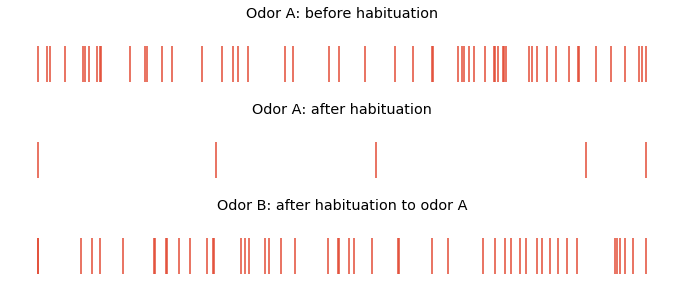

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(3,1,1)
plt.eventplot(KC_before);
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)#
plt.title('Odor A: before habituation')
plt.axis('off')

plt.subplot(3,1,2)
plt.eventplot(KC_after);
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title('Odor A: after habituation')
plt.axis('off')

plt.subplot(3,1,3)
plt.eventplot(KC_odor2);
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title('Odor B: after habituation to odor A')
plt.axis('off')

plt.show()

## Fine Discrimination
### Get all highly correlated odor triplets

In [6]:
odors = normed.columns
correlations = normed.corr(method='pearson')

triples = []
mean_corr = []
for odor in odors:
    corrs = np.array(correlations[odor].values)
    index = np.where((corrs<1)&(corrs>0.8))[0]
    seconds = odors[index]
    if len(seconds) < 2:
        continue
    for i in range(len(seconds)-1):
        for j in range(i+1,len(seconds)):
            r = pearsonr(normed[seconds[i]].values,normed[seconds[j]].values)[0]
            if r > 0.8:
                to_add = (odor,seconds[i],seconds[j])
                triples.append(to_add)
                cor1 = corrs[index[i]]
                cor2 = corrs[index[j]]
                mean_corr.append(sum([cor1,cor2,r])/3)

In [7]:
from utils import jaccard

bc_before = []
bc_after = []
grand_triple = []
from itertools import permutations
for tri in triples:
    per = list(permutations(tri))
    tested = []
    for odorA, odorB, odorC in per:
        if odorA in tested:
            continue
        else:
            tested.append(odorA)
            A = np.array(normed[odorA].values)
            B = np.array(normed[odorB].values)
            C = np.array(normed[odorC].values)
            w = np.array([0.0]*n_orn)
            KCB = get_KC_tag(B,w,R,thresh)
            KCC = get_KC_tag(C,w,R,thresh)
            bc_before.append(jaccard(KCB,KCC))
            w2 = habituate(A,w,alpha=0.05,beta=0.01,steps=50)
            KCB2 = get_KC_tag(B,w2,R,thresh)
            KCC2 = get_KC_tag(C,w2,R,thresh)
            bc_after.append(jaccard(KCB2,KCC2))
            grand_triple.append((odorA, odorB, odorC))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


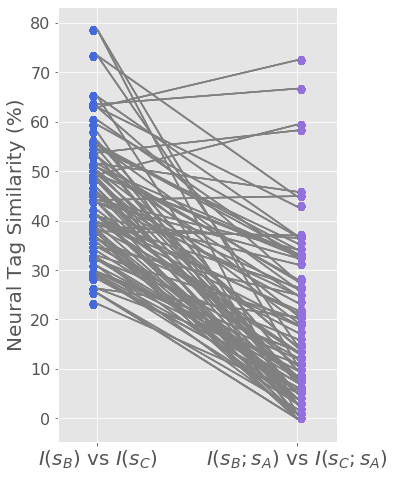

In [8]:
x1 = 1
x2 = 2
fig, ax = plt.subplots(figsize=(5, 8))
for b, a in zip(bc_before, bc_after):
    ax.plot([x1, x2], [b, a], c='gray')

    # Plot the points
    ax.scatter(len(bc_before)*[x1-0.02], bc_before,
               s=60, label=r'$I(s_B) vs I(s_C)$', marker='H',color='royalblue')
    ax.scatter(len(bc_after)*[x2+0.02], bc_after,
               s=60, label=r'$I(s_B; s_A) vs I(s_C; s_A)$', marker='H',color='mediumpurple')

# Fix the axes and labels
ax.set_xticks([1, 2])
_ = ax.set_xticklabels([r'$I(s_B)$'+' vs '+r'$I(s_C)$',r'$I(s_B; s_A)$'+' vs '+r'$I(s_C; s_A)$'], fontsize=24)
#ax.tick_params(axis="y", labelsize=24);
plt.yticks(fontsize=16,fontname='Arial')
plt.xticks(fontsize=20,fontname='Arial')
plt.ylabel('Neural Tag Similarity (%)',fontsize=20,fontname='Arial')
ax.set_xlim(0.8,2.2)
plt.show()

## Background Subtraction

In [9]:
from utils import background_subtraction

sub_linear = background_subtraction(normed,alpha,beta,steps,R,thresh=10,linear=True)
sub_nonlinear = background_subtraction(normed,0.1,0.05,steps,R,thresh=10,linear=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


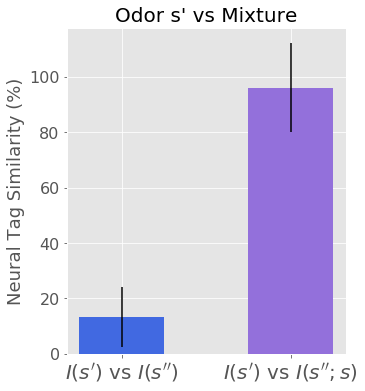

In [10]:
average = sub_linear.median()
average = pd.DataFrame(average)
stds = sub_linear.mad()
plt.subplots(figsize=(5,6))
ind = np.arange(2)
width = 0.5
height = [avg[0] for avg in average.values]
yerr = np.array(stds.values)
fig, ax = plt.bar(ind,height,width,yerr=yerr,color=('royalblue','mediumpurple'))
plt.xticks(np.arange(2),("$I(s')$ vs $I(s'')$","$I(s')$ vs $I(s'';s)$"),fontsize=20,fontname='Arial')
plt.yticks(fontsize=16,fontname='Arial')
plt.ylabel('Neural Tag Similarity (%)',fontsize=18,fontname='Arial')
plt.title("Odor s' vs Mixture",fontsize=20,fontname='Arial')
plt.show()

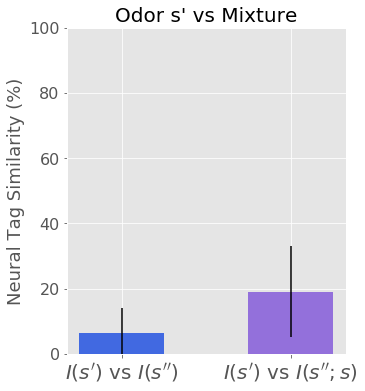

In [11]:
average = sub_nonlinear.median()
average = pd.DataFrame(average)
stds = sub_nonlinear.mad()
plt.subplots(figsize=(5,6))
ind = np.arange(2)
width = 0.5
height = [avg[0] for avg in average.values]
yerr = np.array(stds.values)
fig, ax = plt.bar(ind,height,width,yerr=yerr,color=('royalblue','mediumpurple'))
plt.xticks(np.arange(2),("$I(s')$ vs $I(s'')$","$I(s')$ vs $I(s'';s)$"),fontsize=20,fontname='Arial')
plt.yticks(fontsize=16,fontname='Arial')
plt.ylabel('Neural Tag Similarity (%)',fontsize=18,fontname='Arial')
plt.ylim(0,100);
plt.title("Odor s' vs Mixture",fontsize=20,fontname='Arial')
plt.show()

### Nearest Neighbors

In [12]:
from utils import get_KC_binary

w = np.array([0.0]*n_orn)
KCs = [get_KC_binary(np.array(normed[odor].values),w,R,thresh=10) for odor in normed.columns]
KCs = pd.DataFrame(KCs).T
KCs.columns = normed.columns

In [13]:
from utils import batch_nn

nn_linear = batch_nn(normed,KCs,R,thresh,alpha,beta,steps,linear=True)
nn_nonlinear = batch_nn(normed,KCs,R,thresh,0.1,0.05,steps,linear=False)

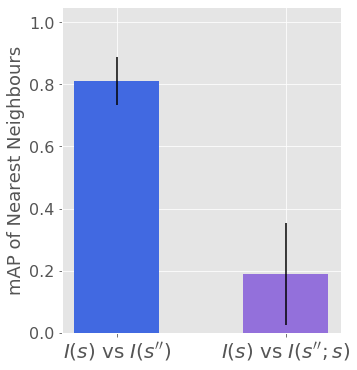

In [14]:
A = nn_linear[['A_sim_before','A_sim_after']]
A.columns = ['Before','After']
average = A.median()
average = pd.DataFrame(average)
stds = A.mad()
plt.subplots(figsize=(5,6))
ind = np.arange(2)
width = 0.5
height = [avg[0] for avg in average.values]
yerr = np.array(stds.values)
fig, ax = plt.bar(ind,height,width,yerr=yerr,color=('royalblue','mediumpurple'))
plt.xticks(np.arange(2),("$I(s)$ vs $I(s'')$","$I(s)$ vs $I(s'';s)$"),fontsize=20,fontname='Arial')
plt.yticks(fontsize=16,fontname='Arial')
plt.ylabel('mAP of Nearest Neighbours',fontsize=18,fontname='Arial')
plt.ylim(0,1.05)
plt.show()

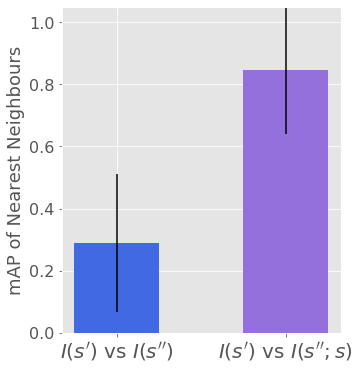

In [15]:
B = nn_linear[['B_sim_before','B_sim_after']]
B.columns = ['Before','After']
average = B.median()
average = pd.DataFrame(average)
stds = B.mad()
plt.subplots(figsize=(5,6))
ind = np.arange(2)
width = 0.5
height = [avg[0] for avg in average.values]
yerr = np.array(stds.values)
fig, ax = plt.bar(ind,height,width,yerr=yerr,color=('royalblue','mediumpurple'))
plt.xticks(np.arange(2),("$I(s')$ vs $I(s'')$","$I(s')$ vs $I(s'';s)$"),fontsize=20,fontname='Arial')
plt.yticks(fontsize=16,fontname='Arial')
plt.ylabel('mAP of Nearest Neighbours',fontsize=18,fontname='Arial')
#plt.title("Odor s' vs Mixture",fontsize=20,fontname='Arial')
plt.ylim(0,1.05)
plt.show()